# **Electric Vehicles Project**

In [2]:
#pip install folium
#!pip install --upgrade seaborn
!pip install xgboost


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Loading The database:

In [6]:
# AWS S3 file listings
!aws s3 ls s3://team2buckets3/alt_fuel_stations.csv
!aws s3 ls s3://team2buckets3/Electric_Vehicle_Population_Data.csv
!aws s3 ls s3://team2buckets3/Electric_Vehicle_Title_and_Registration_Activity.csv

2024-03-17 18:13:17     704669 alt_fuel_stations.csv
2024-03-17 17:47:02   42030494 Electric_Vehicle_Population_Data.csv
2024-03-17 17:47:02  319658341 Electric_Vehicle_Title_and_Registration_Activity.csv


In [7]:
# AWS S3 file copying
!aws s3 cp s3://team2buckets3/alt_fuel_stations.csv ./alt_fuel_stations.csv
!aws s3 cp s3://team2buckets3/Electric_Vehicle_Population_Data.csv ./Electric_Vehicle_Population_Data.csv
!aws s3 cp s3://team2buckets3/Electric_Vehicle_Title_and_Registration_Activity.csv ./Electric_Vehicle_Title_and_Registration_Activity.csv

download: s3://team2buckets3/alt_fuel_stations.csv to ./alt_fuel_stations.csv
download: s3://team2buckets3/Electric_Vehicle_Population_Data.csv to ./Electric_Vehicle_Population_Data.csv
download: s3://team2buckets3/Electric_Vehicle_Title_and_Registration_Activity.csv to ./Electric_Vehicle_Title_and_Registration_Activity.csv


In [8]:
# Reading CSV files into pandas DataFrames
fuel_stations = pd.read_csv('alt_fuel_stations.csv')
ev_population = pd.read_csv('Electric_Vehicle_Population_Data.csv')
ev_registration = pd.read_csv('Electric_Vehicle_Title_and_Registration_Activity.csv')

## Understand the datebase:

### Fuel Stations Data:

In [9]:
print("Displaying Fuel Stations data:")
fuel_stations.head(3)

Displaying Fuel Stations data:


,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,Restricted Access,RD Blends,RD Blends (French),RD Blended with Biodiesel,RD Maximum Biodiesel Level,NPS Unit Name,CNG Station Sells Renewable Natural Gas,LNG Station Sells Renewable Natural Gas,Maximum Vehicle Class,EV Workplace Charging
0,ELEC,City of Lacey - City Hall Parking,420 College St,"At 3rd Ave SE, next to police station",Lacey,WA,98503,NaN,360-491-3214,E,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False
1,ELEC,Seattle-Tacoma International Airport - General...,17801 Pacific Hwy S,"5th floor parking garage; rows D, G, and I",Seattle,WA,98188,NaN,206-787-5388,E,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False
2,ELEC,Avista Corp,1411 E Mission Ave,NaN,Spokane,WA,99252,NaN,509-489-0500,E,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False


In [10]:
# 1. Data Info
print("Data Information:")
fuel_stations.info()

# 2. Summary Statistics
print("\nSummary Statistics for fuel stations data:")
fuel_stations.describe()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 74 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fuel Type Code                           2138 non-null   object 
 1   Station Name                             2138 non-null   object 
 2   Street Address                           2138 non-null   object 
 3   Intersection Directions                  87 non-null     object 
 4   City                                     2138 non-null   object 
 5   State                                    2138 non-null   object 
 6   ZIP                                      2138 non-null   object 
 7   Plus4                                    0 non-null      float64
 8   Station Phone                            2122 non-null   object 
 9   Status Code                              2138 non-null   object 
 10  Expected Date                 

,Plus4,Expected Date,BD Blends,NG Fill Type Code,NG PSI,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,...,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,RD Blends,RD Blends (French),RD Blended with Biodiesel,RD Maximum Biodiesel Level,CNG Station Sells Renewable Natural Gas,LNG Station Sells Renewable Natural Gas
count,0.0,0.0,0.0,0.0,0.0,5.00000,1881.000000,321.000000,2138.000000,2138.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,3.80000,2.332270,3.725857,47.452871,-121.855048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.63318,2.608429,3.888234,0.617638,1.452720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.00000,1.000000,1.000000,45.562567,-124.662924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,2.00000,2.000000,1.000000,47.302726,-122.377587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2.00000,2.000000,2.000000,47.615515,-122.315505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,4.00000,2.000000,4.000000,47.663247,-122.175931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,10.00000,68.000000,20.000000,48.995255,-117.043496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning

In [11]:
# List of unnecessary columns
unnecessary_columns = ['Plus4', 'Expected Date', 'BD Blends', 'NG Fill Type Code', 
                       'NG PSI', 'EV Level1 EVSE Num', 'Hydrogen Status Link', 
                       'NG Vehicle Class', 'LPG Primary', 'E85 Blender Pump', 
                       'Intersection Directions (French)', 'Access Days Time (French)', 
                       'BD Blends (French)', 'Hydrogen Is Retail', 'Federal Agency Code', 
                       'CNG Dispenser Num', 'CNG On-Site Renewable Source', 
                       'CNG Total Compression Capacity', 'CNG Storage Capacity', 
                       'LNG On-Site Renewable Source', 'E85 Other Ethanol Blends', 
                       'EV Pricing (French)', 'LPG Nozzle Types', 'Hydrogen Pressures', 
                       'Hydrogen Standards', 'CNG Fill Type Code', 'CNG PSI', 
                       'CNG Vehicle Class', 'LNG Vehicle Class', 'EV Workplace Charging', 
                       'RD Blends', 'RD Blends (French)', 'RD Blended with Biodiesel', 
                       'RD Maximum Biodiesel Level', 'CNG Station Sells Renewable Natural Gas', 
                       'LNG Station Sells Renewable Natural Gas', 'Access Days Time', 'Cards Accepted', 
                       'EV Other Info', 'EV Network Web', 'Date Last Confirmed', 'Owner Type Code', 
                       'Federal Agency Name' ,'Federal Agency ID']

# Drop unnecessary columns
fuel_stations = fuel_stations.drop(columns=unnecessary_columns)

# Check the updated DataFrame
print(fuel_stations.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fuel Type Code                    2138 non-null   object 
 1   Station Name                      2138 non-null   object 
 2   Street Address                    2138 non-null   object 
 3   Intersection Directions           87 non-null     object 
 4   City                              2138 non-null   object 
 5   State                             2138 non-null   object 
 6   ZIP                               2138 non-null   object 
 7   Station Phone                     2122 non-null   object 
 8   Status Code                       2138 non-null   object 
 9   Groups With Access Code           2138 non-null   object 
 10  EV Level2 EVSE Num                1881 non-null   float64
 11  EV DC Fast Count                  321 non-null    float64
 12  EV Net

In [12]:
# Check for missing values
missing_values = fuel_stations.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Fuel Type Code                         0
Station Name                           0
Street Address                         0
Intersection Directions             2051
City                                   0
State                                  0
ZIP                                    0
Station Phone                         16
Status Code                            0
Groups With Access Code                0
EV Level2 EVSE Num                   257
EV DC Fast Count                    1817
EV Network                             0
Geocode Status                         0
Latitude                               0
Longitude                              0
ID                                     0
Updated At                             0
Open Date                              1
EV Connector Types                     0
Country                                0
Groups With Access Code (French)       0
Access Code                            0
Access Detail Code                  2040

In [13]:
# Filling missing values
fuel_stations['Intersection Directions'].fillna('No directions provided', inplace=True)
fuel_stations['Station Phone'].fillna('', inplace=True)

median_ev_level2 = fuel_stations['EV Level2 EVSE Num'].median()
fuel_stations['EV Level2 EVSE Num'].fillna(median_ev_level2, inplace=True)
fuel_stations['EV DC Fast Count'].fillna(0, inplace=True)
# most_recent_date = fuel_stations['Date Last Confirmed'].max()
# fuel_stations['Date Last Confirmed'].fillna(most_recent_date, inplace=True)
# fuel_stations['Owner Type Code'].fillna('Unknown', inplace=True)
most_common_open_date = fuel_stations['Open Date'].mode()[0]
fuel_stations['Open Date'].fillna(most_common_open_date, inplace=True)
fuel_stations['Access Detail Code'].fillna('Not specified', inplace=True)
fuel_stations['Facility Type'].fillna('Not specified', inplace=True)
fuel_stations['EV Pricing'].fillna('Not specified', inplace=True)
fuel_stations['EV On-Site Renewable Source'].fillna('Not specified', inplace=True)
fuel_stations['Restricted Access'].fillna('Not specified', inplace=True)
fuel_stations['NPS Unit Name'].fillna('Not specified', inplace=True)
fuel_stations['Maximum Vehicle Class'].fillna('Not specified', inplace=True)
print(fuel_stations.isnull().sum())


Fuel Type Code                      0
Station Name                        0
Street Address                      0
Intersection Directions             0
City                                0
State                               0
ZIP                                 0
Station Phone                       0
Status Code                         0
Groups With Access Code             0
EV Level2 EVSE Num                  0
EV DC Fast Count                    0
EV Network                          0
Geocode Status                      0
Latitude                            0
Longitude                           0
ID                                  0
Updated At                          0
Open Date                           0
EV Connector Types                  0
Country                             0
Groups With Access Code (French)    0
Access Code                         0
Access Detail Code                  0
Facility Type                       0
EV Pricing                          0
EV On-Site R

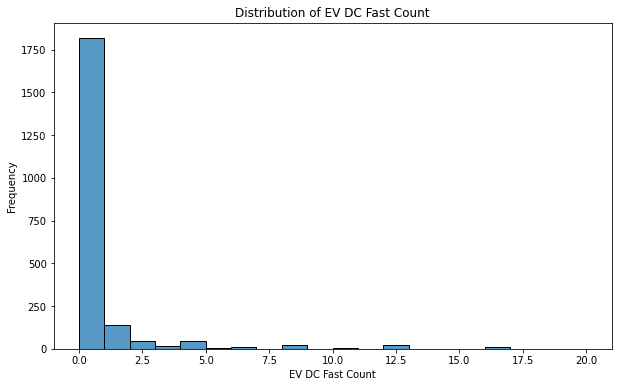

In [14]:
# Distribution of EV DC Fast Count
plt.figure(figsize=(10, 6))
sns.histplot(data=fuel_stations, x='EV DC Fast Count', bins=20)
plt.title("Distribution of EV DC Fast Count")
plt.xlabel("EV DC Fast Count")
plt.ylabel("Frequency")
plt.show()

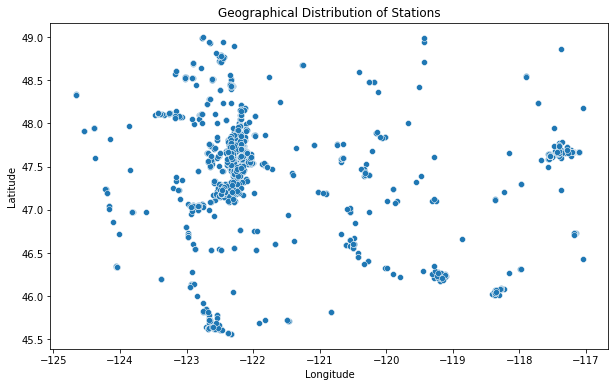

In [15]:
# Scatter plot of Latitude vs Longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fuel_stations, x='Longitude', y='Latitude')
plt.title("Geographical Distribution of Stations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

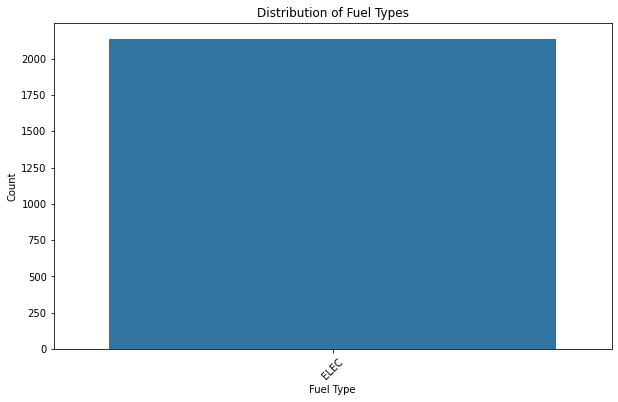

In [16]:
# Geographical Distribution of Stations
map_stations = folium.Map(location=[fuel_stations['Latitude'].mean(), fuel_stations['Longitude'].mean()], zoom_start=4)
for _, station in fuel_stations.iterrows():
    folium.Marker([station['Latitude'], station['Longitude']], popup=station['Station Name']).add_to(map_stations)
map_stations.save('stations_map.html')

# Fuel Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Fuel Type Code', data=fuel_stations)
plt.title("Distribution of Fuel Types")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

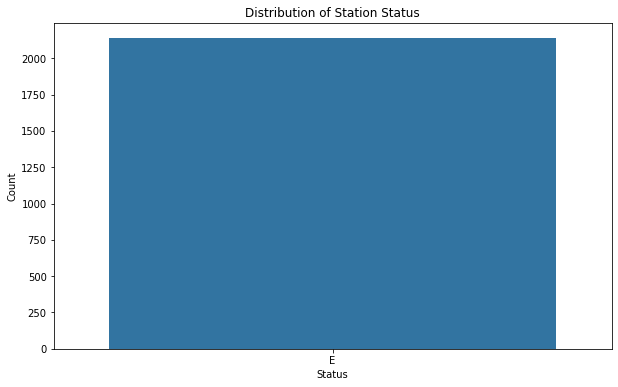

In [17]:
# Station Status Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Status Code', data=fuel_stations)
plt.title("Distribution of Station Status")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()


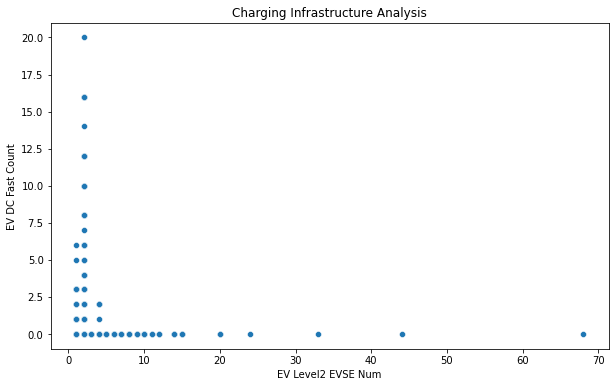

In [18]:
# Charging Infrastructure Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EV Level2 EVSE Num', y='EV DC Fast Count', data=fuel_stations)
plt.title("Charging Infrastructure Analysis")
plt.xlabel("EV Level2 EVSE Num")
plt.ylabel("EV DC Fast Count")
plt.show()

### Handling the Outliers

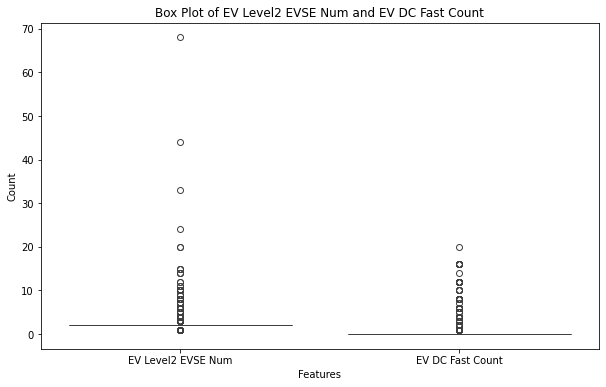

In [19]:
# Create a box plot for 'EV Level2 EVSE Num' and 'EV DC Fast Count'
plt.figure(figsize=(10, 6))
sns.boxplot(data=fuel_stations[['EV Level2 EVSE Num', 'EV DC Fast Count']])
plt.title('Box Plot of EV Level2 EVSE Num and EV DC Fast Count')
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()

In [20]:
fuel_stations.describe()

,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,ID
count,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000
mean,2.292329,0.559401,47.452871,-121.855048,205771.521983
std,2.448945,2.008983,0.617638,1.452720,75149.374226
min,1.000000,0.000000,45.562567,-124.662924,33351.000000
25%,2.000000,0.000000,47.302726,-122.377587,162945.000000
50%,2.000000,0.000000,47.615515,-122.315505,197437.000000
75%,2.000000,0.000000,47.663247,-122.175931,259609.750000
max,68.000000,20.000000,48.995255,-117.043496,330712.000000


### Electric Vehicles Population:

In [21]:
print("The display for the Electric Vehicles Population Data")
ev_population.head(3)

The display for the Electric Vehicles Population Data


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5UXKT0C59G,Yakima,Zillah,WA,98953.0,2016,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14.0,0.0,15.0,206822717,POINT (-120.26317 46.40556),PACIFICORP,5.307700e+10
1,5YJ3E1EA2J,Snohomish,Edmonds,WA,98020.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,21.0,137721636,POINT (-122.37507 47.80807),PUGET SOUND ENERGY INC,5.306105e+10
2,1G1RE6E4XE,Kitsap,Port Orchard,WA,98367.0,2014,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,38.0,0.0,26.0,197718468,POINT (-122.6847073 47.50524),PUGET SOUND ENERGY INC,5.303509e+10


In [22]:
# 1. Data Info
print("Data Information:")
ev_population.info()

# 2. Summary Statistics
print("\nSummary Statistics for EV Population data:")
ev_population.describe()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173533 entries, 0 to 173532
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         173533 non-null  object 
 1   County                                             173528 non-null  object 
 2   City                                               173528 non-null  object 
 3   State                                              173533 non-null  object 
 4   Postal Code                                        173528 non-null  float64
 5   Model Year                                         173533 non-null  int64  
 6   Make                                               173533 non-null  object 
 7   Model                                              173533 non-null  object 
 8   Electric Vehicle Type                              17353

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,173528.000000,173533.000000,173532.000000,173532.000000,173157.000000,1.735330e+05,1.735280e+05
mean,98174.746099,2020.435352,60.148002,1113.254472,29.146670,2.188134e+08,5.297739e+10
std,2411.109685,2.994442,92.644038,8513.543524,14.871778,7.658800e+07,1.567028e+09
min,1545.000000,1997.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2018.000000,0.000000,0.000000,18.000000,1.801662e+08,5.303301e+10
50%,98122.000000,2022.000000,0.000000,0.000000,33.000000,2.271021e+08,5.303303e+10
75%,98370.000000,2023.000000,83.000000,0.000000,42.000000,2.530049e+08,5.305307e+10
max,99577.000000,2024.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.603300e+10


## Data cleaning

In [23]:
# Drop rows with missing values
ev_population = ev_population.dropna()

# Convert 'Postal Code' and 'Legislative District' to integer type
ev_population['Postal Code'] = ev_population['Postal Code'].astype(str)
ev_population['Legislative District'] = ev_population['Legislative District'].astype(int)

# Remove leading/trailing whitespaces and convert text columns to lowercase
ev_population['County'] = ev_population['County'].str.strip().str.lower()
ev_population['City'] = ev_population['City'].str.strip().str.lower()
ev_population['State'] = ev_population['State'].str.strip().str.lower()
ev_population['Make'] = ev_population['Make'].str.strip().str.lower()
ev_population['Model'] = ev_population['Model'].str.strip().str.lower()
ev_population['Electric Vehicle Type'] = ev_population['Electric Vehicle Type'].str.strip().str.lower()
ev_population['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = ev_population['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].str.strip().str.lower()
ev_population['Vehicle Location'] = ev_population['Vehicle Location'].str.strip().str.lower()
ev_population['Electric Utility'] = ev_population['Electric Utility'].str.strip().str.lower()

# Check for duplicate rows and drop them if necessary
ev_population = ev_population.drop_duplicates()

# Reset index after dropping rows
ev_population.reset_index(drop=True, inplace=True)

# Check the cleaned DataFrame
print(ev_population.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173151 entries, 0 to 173150
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         173151 non-null  object 
 1   County                                             173151 non-null  object 
 2   City                                               173151 non-null  object 
 3   State                                              173151 non-null  object 
 4   Postal Code                                        173151 non-null  object 
 5   Model Year                                         173151 non-null  int64  
 6   Make                                               173151 non-null  object 
 7   Model                                              173151 non-null  object 
 8   Electric Vehicle Type                              173151 non-null  object

In [24]:
# Check for missing data
ev_population.isnull().sum()



VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

In [25]:
# Summary Statistics
print("\n Summary Statistics for Electric Vehicles Population data")
print(ev_population.describe())


 Summary Statistics for Electric Vehicles Population data
          Model Year  Electric Range      Base MSRP  Legislative District  \
count  173151.000000   173151.000000  173151.000000         173151.000000   
mean     2020.436989       60.135304    1110.335747             29.146987   
std         2.994179       92.640670    8501.184324             14.871933   
min      1997.000000        0.000000       0.000000              1.000000   
25%      2018.000000        0.000000       0.000000             18.000000   
50%      2022.000000        0.000000       0.000000             33.000000   
75%      2023.000000       83.000000       0.000000             42.000000   
max      2024.000000      337.000000  845000.000000             49.000000   

       DOL Vehicle ID  2020 Census Tract  
count    1.731510e+05       1.731510e+05  
mean     2.188368e+08       5.303982e+10  
std      7.658982e+07       1.620477e+07  
min      4.385000e+03       5.300195e+10  
25%      1.802026e+08       5.30

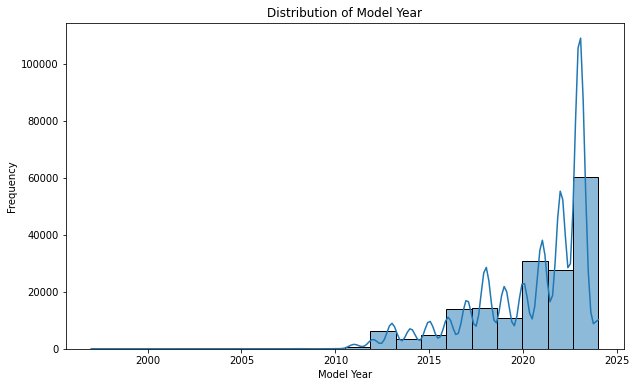

In [26]:
# Distribution of Model Year
plt.figure(figsize=(10, 6))
sns.histplot(ev_population['Model Year'], bins=20, kde=True)
plt.title("Distribution of Model Year")
plt.xlabel("Model Year")
plt.ylabel("Frequency")
plt.show()


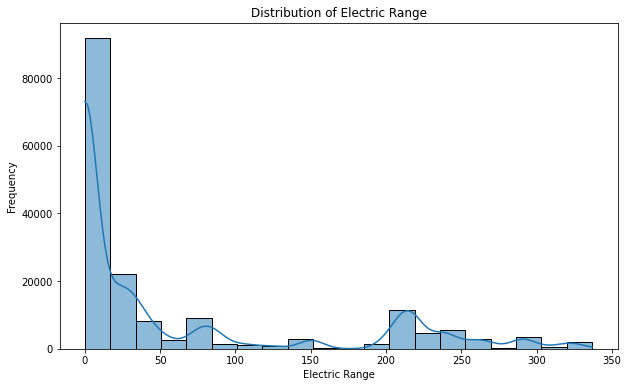

In [27]:
# Distribution of Electric Range
plt.figure(figsize=(10, 6))
sns.histplot(ev_population['Electric Range'], bins=20, kde=True)
plt.title("Distribution of Electric Range")
plt.xlabel("Electric Range")
plt.ylabel("Frequency")
plt.show()

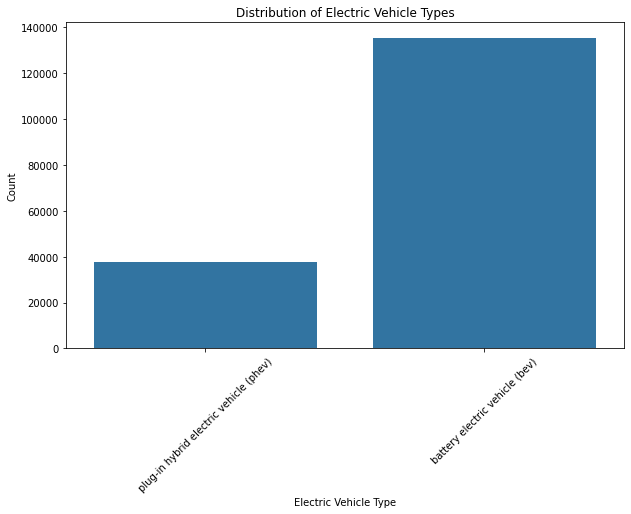

In [28]:
# Distribution of Electric Vehicle Types
plt.figure(figsize=(10, 6))
sns.countplot(x='Electric Vehicle Type', data=ev_population)
plt.title("Distribution of Electric Vehicle Types")
plt.xlabel("Electric Vehicle Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

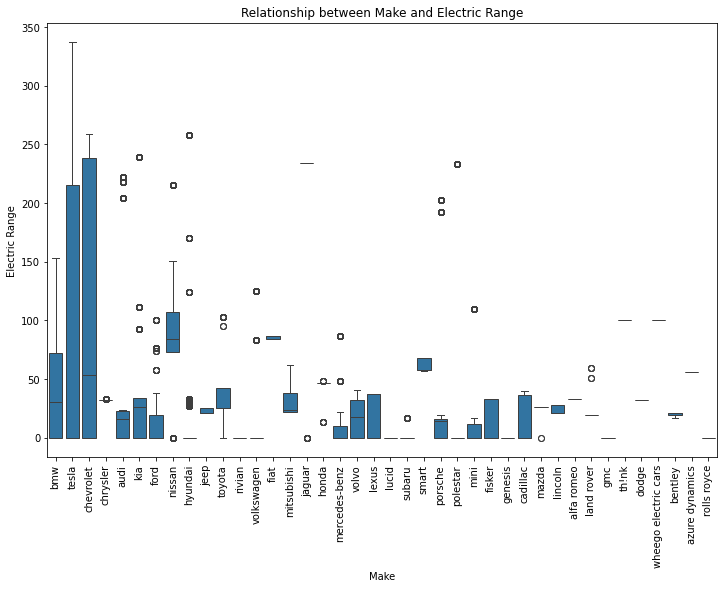

In [29]:
# Relationship between Make and Electric Range
plt.figure(figsize=(12, 8))
sns.boxplot(x='Make', y='Electric Range', data=ev_population)
plt.title("Relationship between Make and Electric Range")
plt.xlabel("Make")
plt.ylabel("Electric Range")
plt.xticks(rotation=90)
plt.show()

### Electric Vehicles Registration:

In [30]:
print("The display for the Electric Vehicles Registration Data")
ev_registration.head(3)

The display for the Electric Vehicles Registration Data


,Clean Alternative Fuel Vehicle Type,VIN (1-10),DOL Vehicle ID,Model Year,Make,Model,Vehicle Primary Use,Electric Range,Odometer Reading,Odometer Code,...,State of Residence,Postal Code,Meets 2019 HB 2042 Sale Price/Value Requirement,2019 HB 2042: Sale Price/Value Requirement,Electric Vehicle Fee Paid,Transportation Electrification Fee Paid,Hybrid Vehicle Electrification Fee Paid,2020 Census Tract,Legislative District,Electric Utility
0,Battery Electric Vehicle (BEV),5YJ3E1EA7J,231013436,2018,TESLA,Model 3,Passenger,215.0,0,Odometer reading is not collected at time of r...,...,WA,98033.0,False,This transaction type is not eligible for the ...,Yes,Yes,No,5.303302e+10,48.0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
1,Battery Electric Vehicle (BEV),5YJXCDE23H,149021127,2017,TESLA,Model X,Passenger,200.0,0,Odometer reading is not collected at time of r...,...,WA,98033.0,False,This transaction type is not eligible for the ...,Yes,Yes,No,5.303302e+10,48.0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
2,Battery Electric Vehicle (BEV),1N4BZ0CP5H,325665931,2017,NISSAN,Leaf,Passenger,107.0,0,Odometer reading is not collected at time of r...,...,WA,98033.0,False,This transaction type is not eligible for the ...,Yes,No,No,5.303302e+10,48.0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)


In [31]:
# 1. Data Info
print(" Data Information")
ev_registration.info()

# 2. Summary Statistics
print("\n Summary Statistics for Electric Vehicles Registration data")
ev_registration.describe()

 Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924803 entries, 0 to 924802
Data columns (total 29 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Clean Alternative Fuel Vehicle Type              924803 non-null  object 
 1   VIN (1-10)                                       924803 non-null  object 
 2   DOL Vehicle ID                                   924803 non-null  int64  
 3   Model Year                                       924803 non-null  int64  
 4   Make                                             924803 non-null  object 
 5   Model                                            924803 non-null  object 
 6   Vehicle Primary Use                              924803 non-null  object 
 7   Electric Range                                   924801 non-null  float64
 8   Odometer Reading                                 924803 non-null  int64  
 9

,DOL Vehicle ID,Model Year,Electric Range,Odometer Reading,Sale Price,Base MSRP,Transaction Year,Postal Code,2020 Census Tract,Legislative District
count,9.248030e+05,924803.000000,924801.000000,924803.000000,9.248030e+05,924801.000000,924803.000000,924741.000000,9.247540e+05,921613.000000
mean,2.087825e+08,2018.323074,87.554102,2867.602018,1.138436e+04,2621.287726,2020.506160,98126.927385,5.294411e+10,29.877476
std,9.524541e+07,3.521393,95.520694,11974.663842,3.224411e+04,13156.193703,2.709137,2859.645490,1.924420e+09,14.781102
min,4.000000e+00,1993.000000,0.000000,0.000000,0.000000e+00,0.000000,2010.000000,745.000000,1.001020e+09,1.000000
25%,1.489764e+08,2016.000000,0.000000,0.000000,0.000000e+00,0.000000,2019.000000,98052.000000,5.303301e+10,18.000000
50%,2.039975e+08,2018.000000,47.000000,0.000000,0.000000e+00,0.000000,2021.000000,98118.000000,5.303303e+10,34.000000
75%,2.499224e+08,2022.000000,200.000000,15.000000,0.000000e+00,0.000000,2023.000000,98366.000000,5.305307e+10,43.000000
max,4.792548e+08,2024.000000,337.000000,962619.000000,1.231202e+07,845000.000000,2024.000000,99901.000000,7.211913e+10,49.000000


## Data Cleaning 

In [32]:
# Drop rows with missing values
ev_registration = ev_registration.dropna()

# Convert 'Postal Code' and 'Legislative District' to integer type
ev_registration['Postal Code'] = ev_registration['Postal Code'].astype(int)
ev_registration['Legislative District'] = ev_registration['Legislative District'].astype(int)

# Remove leading/trailing whitespaces and convert text columns to lowercase
ev_registration['County'] = ev_registration['County'].str.strip().str.lower()
ev_registration['City'] = ev_registration['City'].str.strip().str.lower()
ev_registration['State of Residence'] = ev_registration['State of Residence'].str.strip().str.lower()
ev_registration['Make'] = ev_registration['Make'].str.strip().str.lower()
ev_registration['Model'] = ev_registration['Model'].str.strip().str.lower()
ev_registration['Vehicle Primary Use'] = ev_registration['Vehicle Primary Use'].str.strip().str.lower()
ev_registration['Transaction Type'] = ev_registration['Transaction Type'].str.strip().str.lower()
ev_registration['Electric Utility'] = ev_registration['Electric Utility'].str.strip().str.lower()

# Check for duplicate rows and drop them if necessary
ev_registration = ev_registration.drop_duplicates()

# Reset index after dropping rows
ev_registration.reset_index(drop=True, inplace=True)

# Check the cleaned DataFrame
print(ev_registration.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223329 entries, 0 to 223328
Data columns (total 29 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Clean Alternative Fuel Vehicle Type              223329 non-null  object 
 1   VIN (1-10)                                       223329 non-null  object 
 2   DOL Vehicle ID                                   223329 non-null  int64  
 3   Model Year                                       223329 non-null  int64  
 4   Make                                             223329 non-null  object 
 5   Model                                            223329 non-null  object 
 6   Vehicle Primary Use                              223329 non-null  object 
 7   Electric Range                                   223329 non-null  float64
 8   Odometer Reading                                 223329 non-null  int64  
 9   Odometer Code  

In [33]:
# Check for missing data
ev_registration.isnull().sum()

Clean Alternative Fuel Vehicle Type                0
VIN (1-10)                                         0
DOL Vehicle ID                                     0
Model Year                                         0
Make                                               0
Model                                              0
Vehicle Primary Use                                0
Electric Range                                     0
Odometer Reading                                   0
Odometer Code                                      0
New or Used Vehicle                                0
Sale Price                                         0
Sale Date                                          0
Base MSRP                                          0
Transaction Type                                   0
DOL Transaction Date                               0
Transaction Year                                   0
County                                             0
City                                          

In [34]:
# List of unnecessary columns to be removed
columns_to_drop = ['Electric Vehicle Fee Paid', 'Transportation Electrification Fee Paid', 'Hybrid Vehicle Electrification Fee Paid']

# Drop unnecessary columns
ev_registration= ev_registration.drop(columns=columns_to_drop, axis=1)

# Check the cleaned DataFrame
print(ev_registration.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223329 entries, 0 to 223328
Data columns (total 26 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Clean Alternative Fuel Vehicle Type              223329 non-null  object 
 1   VIN (1-10)                                       223329 non-null  object 
 2   DOL Vehicle ID                                   223329 non-null  int64  
 3   Model Year                                       223329 non-null  int64  
 4   Make                                             223329 non-null  object 
 5   Model                                            223329 non-null  object 
 6   Vehicle Primary Use                              223329 non-null  object 
 7   Electric Range                                   223329 non-null  float64
 8   Odometer Reading                                 223329 non-null  int64  
 9   Odometer Code  

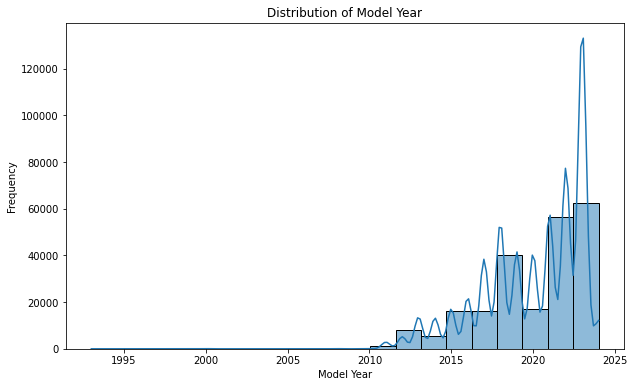

In [35]:
# Distribution of Model Year
plt.figure(figsize=(10, 6))
sns.histplot(ev_registration['Model Year'], bins=20, kde=True)
plt.title("Distribution of Model Year")
plt.xlabel("Model Year")
plt.ylabel("Frequency")
plt.show()

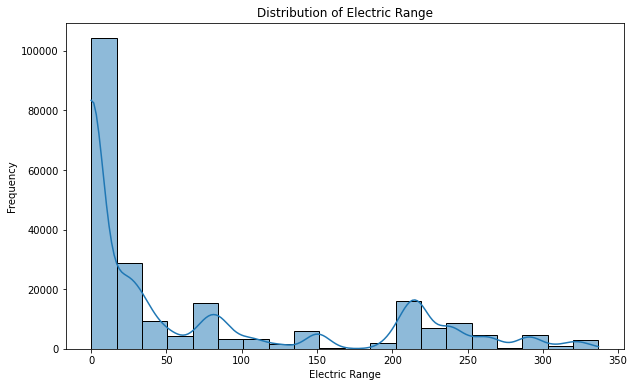

In [36]:
# Distribution of Electric Range
plt.figure(figsize=(10, 6))
sns.histplot(ev_registration['Electric Range'], bins=20, kde=True)
plt.title("Distribution of Electric Range")
plt.xlabel("Electric Range")
plt.ylabel("Frequency")
plt.show()

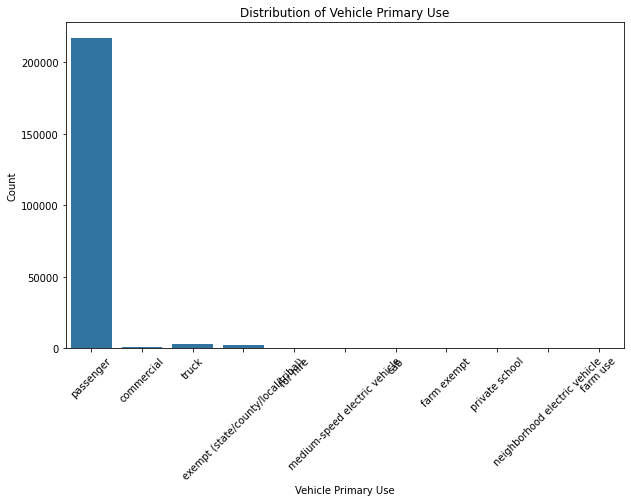

In [37]:
# Distribution of Vehicle Primary Use
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle Primary Use', data=ev_registration)
plt.title("Distribution of Vehicle Primary Use")
plt.xlabel("Vehicle Primary Use")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

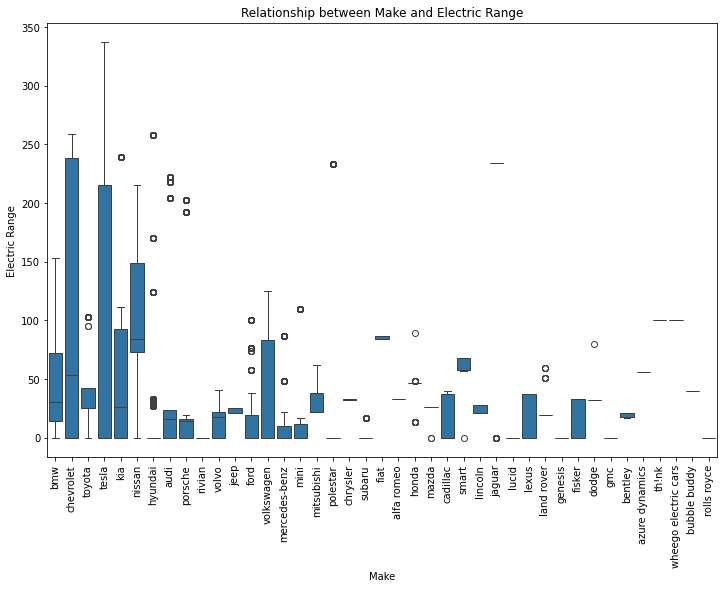

In [38]:
# Relationship between Make and Electric Range
plt.figure(figsize=(12, 8))
sns.boxplot(x='Make', y='Electric Range', data=ev_registration)
plt.title("Relationship between Make and Electric Range")
plt.xlabel("Make")
plt.ylabel("Electric Range")
plt.xticks(rotation=90)
plt.show()

### Handling the Outliers

## Data Scrubbing

In [39]:
station_counts = fuel_stations.groupby('ZIP').size().reset_index(name='num_stations_ZIP')
station_counts

,ZIP,num_stations_ZIP
0,98001,6
1,98002,6
2,98003,10
3,98004,152
4,98005,70
...,...,...
310,99354,2
311,99361,1
312,99362,19
313,99403,1


In [40]:
# Add the number of stations per ZIP code to ev population data
ev_population = pd.merge(ev_population, station_counts, left_on='Postal Code', right_on='ZIP', how='left')
ev_population.drop(columns=['ZIP'],inplace=True)
ev_population.head(3)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,num_stations_ZIP
0,5UXKT0C59G,yakima,zillah,wa,98953.0,2016,bmw,x5,plug-in hybrid electric vehicle (phev),not eligible due to low battery range,14.0,0.0,15,206822717,point (-120.26317 46.40556),pacificorp,5.307700e+10,NaN
1,5YJ3E1EA2J,snohomish,edmonds,wa,98020.0,2018,tesla,model 3,battery electric vehicle (bev),clean alternative fuel vehicle eligible,215.0,0.0,21,137721636,point (-122.37507 47.80807),puget sound energy inc,5.306105e+10,NaN
2,1G1RE6E4XE,kitsap,port orchard,wa,98367.0,2014,chevrolet,volt,plug-in hybrid electric vehicle (phev),clean alternative fuel vehicle eligible,38.0,0.0,26,197718468,point (-122.6847073 47.50524),puget sound energy inc,5.303509e+10,NaN


In [41]:
station_counts_city = fuel_stations.groupby('City').size().reset_index(name='num_stations_city')
# Lower case column City to match ev_population format
station_counts_city['City'] = station_counts_city['City'].str.lower()
station_counts_city

,City,num_stations_city
0,8900 e. buckeye ave.,1
1,aberdeen,9
2,airway heights,8
3,anacortes,15
4,arlington,8
...,...,...
213,yakima,20
214,yelm,1
215,zillah,2
216,lburien,1


In [42]:
# Add the number of stations per city to ev population data
ev_population = pd.merge(ev_population, station_counts_city, on='City', how='left')
ev_population.head(3)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,num_stations_ZIP,num_stations_city
0,5UXKT0C59G,yakima,zillah,wa,98953.0,2016,bmw,x5,plug-in hybrid electric vehicle (phev),not eligible due to low battery range,14.0,0.0,15,206822717,point (-120.26317 46.40556),pacificorp,5.307700e+10,NaN,2.0
1,5YJ3E1EA2J,snohomish,edmonds,wa,98020.0,2018,tesla,model 3,battery electric vehicle (bev),clean alternative fuel vehicle eligible,215.0,0.0,21,137721636,point (-122.37507 47.80807),puget sound energy inc,5.306105e+10,NaN,17.0
2,1G1RE6E4XE,kitsap,port orchard,wa,98367.0,2014,chevrolet,volt,plug-in hybrid electric vehicle (phev),clean alternative fuel vehicle eligible,38.0,0.0,26,197718468,point (-122.6847073 47.50524),puget sound energy inc,5.303509e+10,NaN,6.0


In [43]:
register_counts = ev_registration.groupby('VIN (1-10)').size().reset_index(name='num_register')
register_counts

,VIN (1-10),num_register
0,1C4JJXN60P,40
1,1C4JJXN61P,40
2,1C4JJXN62P,38
3,1C4JJXN63P,46
4,1C4JJXN64P,35
...,...,...
10794,ZASPATDW5R,2
10795,ZASPATDW6R,1
10796,ZASPATDW7R,2
10797,ZASPATDW8R,3


In [44]:
# Add the number of registers to ev population data
ev_population = pd.merge(ev_population, register_counts, on='VIN (1-10)', how='left')
ev_population.head(3)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,num_stations_ZIP,num_stations_city,num_register
0,5UXKT0C59G,yakima,zillah,wa,98953.0,2016,bmw,x5,plug-in hybrid electric vehicle (phev),not eligible due to low battery range,14.0,0.0,15,206822717,point (-120.26317 46.40556),pacificorp,5.307700e+10,NaN,2.0,33.0
1,5YJ3E1EA2J,snohomish,edmonds,wa,98020.0,2018,tesla,model 3,battery electric vehicle (bev),clean alternative fuel vehicle eligible,215.0,0.0,21,137721636,point (-122.37507 47.80807),puget sound energy inc,5.306105e+10,NaN,17.0,372.0
2,1G1RE6E4XE,kitsap,port orchard,wa,98367.0,2014,chevrolet,volt,plug-in hybrid electric vehicle (phev),clean alternative fuel vehicle eligible,38.0,0.0,26,197718468,point (-122.6847073 47.50524),puget sound energy inc,5.303509e+10,NaN,6.0,16.0


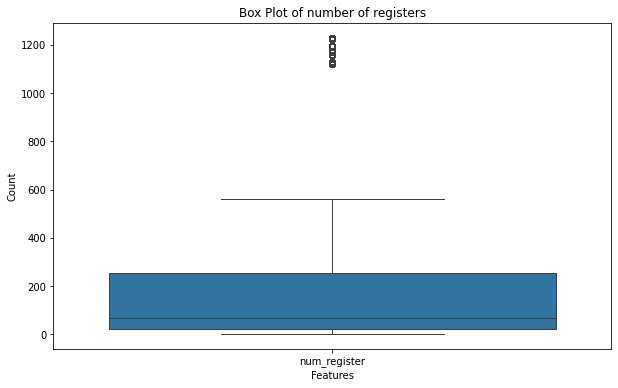

In [45]:
# Create a box plot for num_register
plt.figure(figsize=(10, 6))
sns.boxplot(data=ev_population[['num_register']])
plt.title('Box Plot of number of registers')
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()

In [46]:
ev_population['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique()

array(['not eligible due to low battery range',
       'clean alternative fuel vehicle eligible',
       'eligibility unknown as battery range has not been researched'],
      dtype=object)

In [47]:
one_hot_encoded_df = pd.get_dummies(ev_population['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], prefix='CAFV')
ev_population = pd.concat([ev_population, one_hot_encoded_df], axis=1)
ev_population.drop(columns=['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], inplace=True)

In [48]:
ev_population.head(3)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,...,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,num_stations_ZIP,num_stations_city,num_register,CAFV_clean alternative fuel vehicle eligible,CAFV_eligibility unknown as battery range has not been researched,CAFV_not eligible due to low battery range
0,5UXKT0C59G,yakima,zillah,wa,98953.0,2016,bmw,x5,plug-in hybrid electric vehicle (phev),14.0,...,206822717,point (-120.26317 46.40556),pacificorp,5.307700e+10,NaN,2.0,33.0,0,0,1
1,5YJ3E1EA2J,snohomish,edmonds,wa,98020.0,2018,tesla,model 3,battery electric vehicle (bev),215.0,...,137721636,point (-122.37507 47.80807),puget sound energy inc,5.306105e+10,NaN,17.0,372.0,1,0,0
2,1G1RE6E4XE,kitsap,port orchard,wa,98367.0,2014,chevrolet,volt,plug-in hybrid electric vehicle (phev),38.0,...,197718468,point (-122.6847073 47.50524),puget sound energy inc,5.303509e+10,NaN,6.0,16.0,1,0,0


In [49]:
ev_population['Electric Vehicle Type'].unique()

array(['plug-in hybrid electric vehicle (phev)',
       'battery electric vehicle (bev)'], dtype=object)

In [50]:
option_map = {'plug-in hybrid electric vehicle (phev)': 1, 'battery electric vehicle (bev)': 0}
ev_population['Electric Vehicle Type'] = ev_population['Electric Vehicle Type'].map(option_map)
ev_population.head(3)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,...,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,num_stations_ZIP,num_stations_city,num_register,CAFV_clean alternative fuel vehicle eligible,CAFV_eligibility unknown as battery range has not been researched,CAFV_not eligible due to low battery range
0,5UXKT0C59G,yakima,zillah,wa,98953.0,2016,bmw,x5,1,14.0,...,206822717,point (-120.26317 46.40556),pacificorp,5.307700e+10,NaN,2.0,33.0,0,0,1
1,5YJ3E1EA2J,snohomish,edmonds,wa,98020.0,2018,tesla,model 3,0,215.0,...,137721636,point (-122.37507 47.80807),puget sound energy inc,5.306105e+10,NaN,17.0,372.0,1,0,0
2,1G1RE6E4XE,kitsap,port orchard,wa,98367.0,2014,chevrolet,volt,1,38.0,...,197718468,point (-122.6847073 47.50524),puget sound energy inc,5.303509e+10,NaN,6.0,16.0,1,0,0


# Balancing the Data

In [51]:
# Display the first few rows of the dataset
print(ev_population.head())

   VIN (1-10)     County          City State Postal Code  Model Year  \
0  5UXKT0C59G     yakima        zillah    wa     98953.0        2016   
1  5YJ3E1EA2J  snohomish       edmonds    wa     98020.0        2018   
2  1G1RE6E4XE     kitsap  port orchard    wa     98367.0        2014   
3  2C4RC1L76M     skagit           bow    wa     98232.0        2021   
4  5YJ3E1EA2J   thurston       olympia    wa     98513.0        2018   

        Make     Model  Electric Vehicle Type  Electric Range  ...  \
0        bmw        x5                      1            14.0  ...   
1      tesla   model 3                      0           215.0  ...   
2  chevrolet      volt                      1            38.0  ...   
3   chrysler  pacifica                      1            32.0  ...   
4      tesla   model 3                      0           215.0  ...   

   DOL Vehicle ID                Vehicle Location        Electric Utility  \
0       206822717     point (-120.26317 46.40556)              pacifi

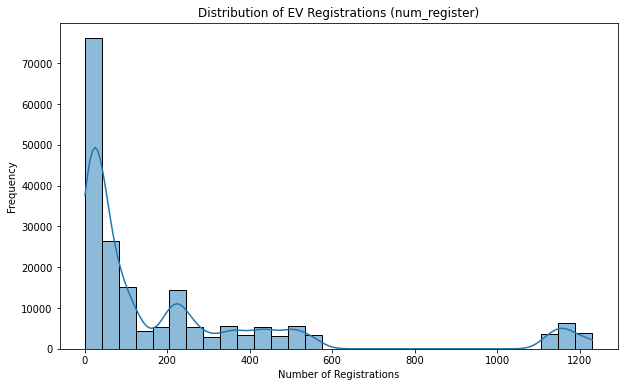

In [52]:
# Plotting the distribution of 'num_register'
plt.figure(figsize=(10, 6))
sns.histplot(ev_population['num_register'], kde=True, bins=30)
plt.title('Distribution of EV Registrations (num_register)')
plt.xlabel('Number of Registrations')
plt.ylabel('Frequency')
plt.show()


In [53]:
# Calculating summary statistics
print(ev_population['num_register'].describe())

count    190477.000000
mean        209.125695
std         307.440353
min           1.000000
25%          23.000000
50%          66.000000
75%         254.000000
max        1230.000000
Name: num_register, dtype: float64


In [54]:
# Checking for any potential outliers
print("\nPotential Outliers:")
print(ev_population['num_register'].quantile([0.01, 0.99]))


Potential Outliers:
0.01       2.0
0.99    1223.0
Name: num_register, dtype: float64


###  The histogram indicates a right-skewed distribution of the num_register variable, with a long tail towards higher registration numbers. This skewness can affect regression model performance because many algorithms assume a normal distribution of the target variable.

## Further Data Cleaning

In [55]:
# Identify columns with a high percentage of missing values
missing_value_threshold = 0.5  # Threshold
high_missing_cols = [col for col in ev_population.columns if ev_population[col].isnull().mean() > missing_value_threshold]
# Drop these columns
ev_population_cleaned = ev_population.drop(columns=high_missing_cols)

# Identify columns with a single unique value
low_variance_cols = [col for col in ev_population_cleaned.columns if ev_population_cleaned[col].nunique() <= 1]

# Drop these columns
ev_population_cleaned = ev_population_cleaned.drop(columns=low_variance_cols)

# Finally, check for remaining missing values
missing_data = ev_population_cleaned.isnull().sum()
missing_data = missing_data[missing_data > 0]

print("Columns dropped due to high missing values or low variance:", high_missing_cols + low_variance_cols)
print("\nRemaining columns with missing values:", missing_data)

Columns dropped due to high missing values or low variance: ['num_stations_ZIP', 'State']

Remaining columns with missing values: num_stations_city    12890
num_register           144
dtype: int64


### - For num_register, since this is our target variable, and there are only 144 missing entries out of over 190,000, it's reasonable to drop these records as they represent a tiny fraction of the dataset.

### - For num_stations_city, which is likely an important predictor, we should impute these missing values. A sensible imputation might be to use the median value, as the mean can be skewed by outliers, which we've seen in the distribution of num_register.

In [56]:
# Drop rows where the target variable 'num_register' is missing
ev_population_cleaned = ev_population_cleaned.dropna(subset=['num_register'])

# Impute missing values in 'num_stations_city' with the median
num_stations_city_median = ev_population_cleaned['num_stations_city'].median()
ev_population_cleaned['num_stations_city'].fillna(num_stations_city_median, inplace=True)

# Check if there are any more missing values
remaining_missing_data = ev_population_cleaned.isnull().sum()
print("Remaining columns with missing values after imputation:", remaining_missing_data)

# Check the first few entries of the cleaned dataframe
print("\nFirst few entries in the cleaned dataset:")
print(ev_population_cleaned.head())


Remaining columns with missing values after imputation: VIN (1-10)                                                           0
County                                                               0
City                                                                 0
Postal Code                                                          0
Model Year                                                           0
Make                                                                 0
Model                                                                0
Electric Vehicle Type                                                0
Electric Range                                                       0
Base MSRP                                                            0
Legislative District                                                 0
DOL Vehicle ID                                                       0
Vehicle Location                                                     0
Electric Utility     

## Addressing Skewness of the Target Variable

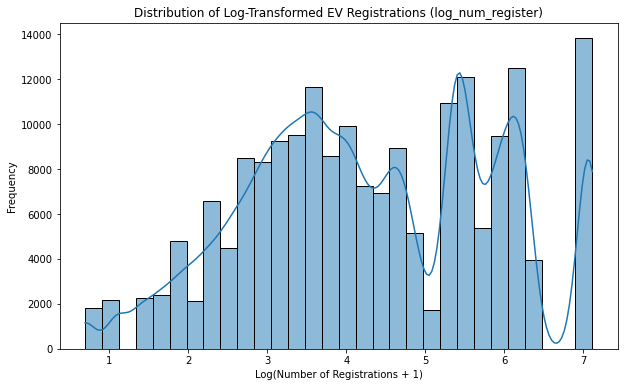

count    190477.000000
mean          4.315535
std           1.554570
min           0.693147
25%           3.178054
50%           4.204693
75%           5.541264
max           7.115582
Name: log_num_register, dtype: float64


In [57]:
# Apply log transformation
ev_population_cleaned['log_num_register'] = np.log1p(ev_population_cleaned['num_register'])

# Plotting the distribution of the transformed 'num_register'
plt.figure(figsize=(10, 6))
sns.histplot(ev_population_cleaned['log_num_register'], kde=True, bins=30)
plt.title('Distribution of Log-Transformed EV Registrations (log_num_register)')
plt.xlabel('Log(Number of Registrations + 1)')
plt.ylabel('Frequency')
plt.show()

# Calculate the summary statistics of the transformed variable
print(ev_population_cleaned['log_num_register'].describe())

# Preprocessing Steps Before Model Training

In [58]:
# Final feature selection 
final_features = ['County', 'City', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Electric Range', 'num_stations_city']

# Splitting the dataset into features and target variable
X = ev_population_cleaned[final_features]
y = ev_population_cleaned['log_num_register']

# Encoding categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Splitting the data into training, validation, and test sets (60%, 20%, 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Printing the shapes of the splits
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Training features shape: (114286, 1218)
Validation features shape: (38095, 1218)
Test features shape: (38096, 1218)
Training labels shape: (114286,)
Validation labels shape: (38095,)
Test labels shape: (38096,)


# Modeling:

In [ ]:
# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

# Prepare a DataFrame to collect metrics
model_metrics = pd.DataFrame(index=models.keys(), columns=['RMSE', 'R2', 'MAE'])

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_val_pred = model.predict(X_val)  # Predict on validation set
    model_metrics.loc[model_name, 'RMSE'] = mean_squared_error(y_val, y_val_pred, squared=False)
    model_metrics.loc[model_name, 'R2'] = r2_score(y_val, y_val_pred)
    model_metrics.loc[model_name, 'MAE'] = mean_absolute_error(y_val, y_val_pred)

# Display the metrics
model_metrics = model_metrics.sort_values('RMSE')  # Sort by RMSE
print(model_metrics)

# Metric 1: Charging Station Density

In [ ]:
total_charging_stations = fuel_stations.shape[0]
total_population = 1000000
charging_station_density = total_charging_stations / total_population

In [ ]:
print("charging station density")
charging_station_density

# Metric 2: Electric Vehicle Market Share
# Calculate the percentage of new vehicle registrations that are electric vehicles

In [ ]:
total_new_vehicle_registrations = 5000  
total_ev_new_registrations = 1500  
ev_market_share = (total_ev_new_registrations / total_new_vehicle_registrations) * 100

In [ ]:
print("electric vehicle market share")
ev_market_share

# Metric 3: Range Anxiety Reduction
# Calculate the average electric range of vehicles registered over time

In [ ]:
average_ev_range = ev_registration['Electric Range'].mean()

In [ ]:
print("average electric vehicles registered over time")
average_ev_range

# Metric 4: Vehicle Turnover Rate
# Calculate the rate at which older gasoline-powered vehicles are replaced with new electric vehicles

In [ ]:
total_gasoline_vehicles = 8000  
total_ev_vehicles = 2500  
vehicle_turnover_rate = (total_ev_vehicles / total_gasoline_vehicles) * 100


In [ ]:
print("vehicle turnover rate")
vehicle_turnover_rate

# Metric 5: Economic Impact
# Example economic impact calculation

In [ ]:
job_creation = 500  
revenue_from_sales = 1000000  
fuel_cost_savings = 500000  

# Total economic impact



In [ ]:
total_economic_impact = job_creation + revenue_from_sales + fuel_cost_savings

In [ ]:
print("Metrics:")
print("1. Charging Station Density (per capita):", charging_station_density)
print("2. Electric Vehicle Market Share (%):", ev_market_share)
print("3. Average Electric Vehicle Range (miles):", average_ev_range)
print("4. Vehicle Turnover Rate (%):", vehicle_turnover_rate)
print("5. Economic Impact ($):", total_economic_impact)

### TO BE DELETED
- Data Preparation
- Data Scrubbing:
- What data cleansing techniques will you apply?
- Feature Selection: Which fields from your data will you use/exclude?
- Feature Creation: Which fields will be combined or bucketed?
- Feature Transformation: What other transformations (such as one hot encoding, etc.) will you apply to your data?
- How will you balance your data set?
- How will you split your dataset?